In [2]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
def read_file( filename, test_size, seed, retain_quantile = 0 ):
    """
    seed: int
        seed for the train/test split
    
    retain_prop: 0 ~ 1 float
        proportion of users that rate the most items will be retained
    """

    # movielens, column order: user id, item id, ratings and timestamp
    # the fourth column is the timestamp, exclude it
    if '.csv' in filename:
        header = 'infer'
        sep = ','
    elif '.data' in filename:
        sep = '\t'
        header = None
    else:
        sep = '::'
        header = None
    
    data = pd.read_csv( filename, sep = sep, header = header, engine = 'python' )
    data = data.iloc[ :, 0:3 ]
    # data = data.astype('float')
    column_names  = [ 'user_ids', 'item_ids', 'ratings' ]
    data.columns = column_names

    # train test split the dat and make sure all the items and users 
    # that are in the testing data has been seen in training
    train, test = train_test_split( data, test_size = test_size, random_state = seed )
    contain_items = test['item_ids'].isin( train['item_ids'].unique() )
    contain_users = test['user_ids'].isin( train['user_ids'].unique() )
    test = test[ contain_users & contain_items ]
    
    # only retain users that are frequently rating
    if retain_quantile:        
        histogram_counts = train['user_ids'].value_counts()
        df_value_counts  = pd.DataFrame( histogram_counts > histogram_counts.quantile(0.5) )
        df_value_counts  = df_value_counts.reset_index()
        frequent_users   = df_value_counts.loc[ df_value_counts['user_ids'], 'index' ]
        train = train[ train['user_ids'].isin(frequent_users) ]
        test  = test[ test['user_ids'].isin(frequent_users) ]   
    
    return train, test

In [10]:
"""
BX-Book-Ratings.csv
final_rating.csv
u.data
ratings.dat
"""

TESTSIZE = 0.2
SEED = 1234
FILENAME = 'data/final_rating.csv'
# RETAIN = 0.8

train, test = read_file( FILENAME, TESTSIZE, SEED )
print(train.shape)
print(test.shape)
train.head()

(928, 3)
(229, 3)


user_ids  item_ids  ratings
661         84        80        2
319         37       129        2
1135       136        52        2
587         74        64        2
1107       134        77        0

In [ ]:
generation = 2
pop_size = 5

In [11]:
from recommender import BIKNN, GABIKNN

In [12]:
# this runs a single BIKNN
# the fit stage is about 646 seconds, 10.7 minute
start1 = time.time()

biknn1 = BIKNN( K = 20, B1 = 25, B2 = 25, iterations = 100000 )
biknn1.fit( data = train, column_names = [ 'user_ids', 'item_ids', 'ratings' ] )

# a boolean value indicating whether you have fitted the model
# biknn1.is_fitted

end1 = time.time()
elapse1 = end1 - start1
elapse1

0.7483010292053223

In [13]:
# test around 140 seconds, 2.3 minutes
start2 = time.time()

pred = biknn1.predict(test)

end2 = time.time()
elapse2 = end2 - start2
elapse2

0.636350154876709

In [14]:
biknn1.evaluate( pred, test['ratings'] )

0.46937630261381524

In [15]:
start3 = time.time()

ga1 = GABIKNN( 
    generation = 2,
    pop_size = 5,
    low = 0, 
    high = 100, 
    retain_rate = 0.5, 
    mutate_rate = 0.2,
    BIKNN = biknn1,
    verbose = True
)
ga1.fit(test)

end3 = time.time()
elapse3 = end3 - start3
elapse3

generation 1's best chromo: info(cost=0.39680750065686377, chromo=[83, 13])
generation 2's best chromo: info(cost=0.39680750065686377, chromo=[83, 13])


9.359618902206421

In [16]:
ga1.generation_history

[info(cost=0.39680750065686377, chromo=[83, 13]),
 info(cost=0.39680750065686377, chromo=[83, 13])]

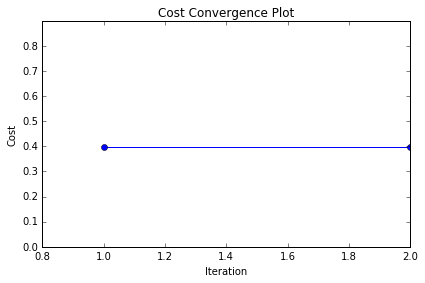

In [17]:
ga1.convergence_plot()